In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
from model_trainer import ModelTrainer
from utils import *
from data_loader import load_data, generate_dataset_g
from nn_modules import View
from nn_models import LeNet, aliG

In [2]:
print("pytorch version: ",torch.__version__)

pytorch version:  0.5.0a0


In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

Using GPU:  GeForce GTX 1080 Ti


## Loading the data (MNIST)

In [4]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=False)

train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [5]:
print("# of training samples : "+str(len(train_input)))

# of training samples : 1000


In [6]:
train_target[0].type()

'torch.cuda.LongTensor'

## 1) LeNet with disjoint trainset and testset

In [7]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

In [8]:
crossEntropyClassesWeigths = computeClassesWeights(train_target)

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.02235554           0.245      0.00214487           0.183
10                   0.00169275           0.948      0.00028155           0.899
20                   0.00047750           0.990      0.00020815           0.922
30                   0.00015133           1.000      0.00021134           0.929
40                   0.00007432           1.000      0.00018635           0.942
49                   0.00004626           1.000      0.00019528           0.946
*******************************************************************************


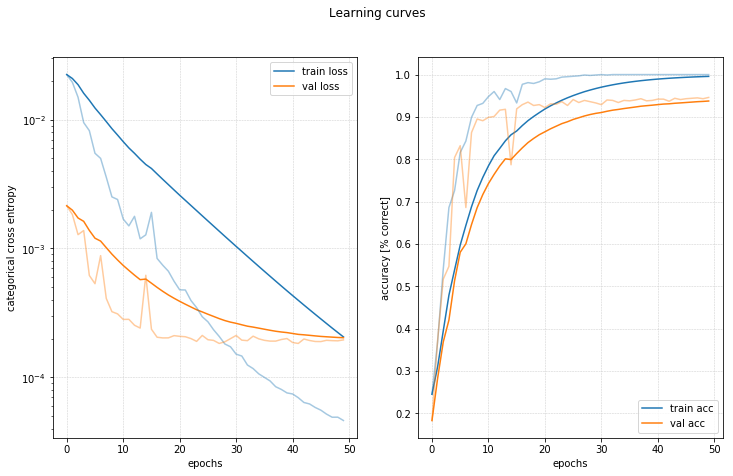

In [9]:
model = LeNet()

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.08

mt = ModelTrainer(model, loss_fun, optim.SGD(model.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=50, batch_size=100, verbose=10)
mt.plot_training("Learning curves")

## 2) Extract layers activations examples

In [10]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [11]:
#Can use the handle to remove the hook, don't execute twice on 
#the same handle, or you won't be able to remove the first
#instance of the hook
output_d, handles_d  = spyOn([model.conv2, model.fc1], ['convolution 2', 'FC_1'], True)

In [12]:
model(train_input[0:10].reshape(-1, 1, 28, 28))

captured output at layer : Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
captured output at layer : Linear(in_features=256, out_features=200, bias=True)


tensor([[ -3.7082,  -1.2703,  -5.3630,   8.4080, -10.0133,  14.5188,  -7.3047,
          -6.1098,   3.1743,  -0.8415],
        [ 13.5110,  -7.8139,   0.2901,  -5.0014,  -8.6682,   0.5146,  -0.9718,
           0.8688,  -6.1481,   6.0487],
        [ -7.8451,  -0.3813,   0.3514,   2.2961,  11.7289,  -1.0803,  -2.8884,
           0.3060,  -4.8522,   1.6768],
        [ -2.6046,  14.1325,   2.0621,  -6.8741,  -1.5183,  -8.3891,  -1.1197,
           3.5879,   2.2178,  -5.4224],
        [ -8.4593,  -1.9612,  -4.8350,   0.5978,   5.5928,  -2.4421, -10.2508,
           2.3220,   2.5775,  14.2542],
        [  1.1806,  -5.4223,  12.9875,   4.4859, -11.3161,  -3.3167,  -3.7357,
           1.2982,   2.5721,  -0.1977],
        [ -6.7754,  10.1104,   0.6030,  -0.7785,  -1.8016,  -1.0024,  -0.7854,
          -2.2378,   2.5189,  -2.6136],
        [ -1.9615,  -6.5883,   1.3567,  21.1734, -13.1378,   5.3230, -15.3278,
          -2.2770,   3.4332,   4.1578],
        [ -5.8064,   9.3244,  -2.7094,  -3.0329,

In [13]:
output_d['convolution 2'].reshape(10, -1).shape

torch.Size([10, 1024])

In [14]:
remove_spying(handles_d)

## 3) Differentiate layer activation from training sample than one from a testing sample

In [15]:
#Size of input vector can be changed
modelG = aliG(142)

In [16]:
debug_layers_dims(modelG, [1, 1, 142])

******************** Debugging layers sizes: ********************
input_shape= (_,1,142)
------------------
Conv1d(1, 32, kernel_size=(8,), stride=(1,))
(_,1,142) --> (_,32,135)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,32,135) --> (_,32,67)
------------------
Conv1d(32, 128, kernel_size=(5,), stride=(1,))
(_,32,67) --> (_,128,63)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,128,63) --> (_,128,31)
------------------
Conv1d(128, 16, kernel_size=(3,), stride=(1,))
(_,128,31) --> (_,16,29)
------------------
MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
(_,16,29) --> (_,16,14)
------------------
View(_, [-1])
(_,16,14) --> (_,224)
------------------
Linear(in_features=224, out_features=100, bias=True)
(_,224) --> (_,100)
------------------
Linear(in_features=100, out_features=32, bias=True)
(_,100) --> (_,32)
------------------
Linear(in_features=32, out_

tensor([[0.0112],
        [0.0048]], grad_fn=<ThAddmmBackward>)

In [17]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)

In [18]:
layer = model.fc1
layer_name = "fc1"

In [19]:
(g_train_input, g_train_target), (g_test_input, g_test_target) = generate_dataset_g(model, train_dataset, test_dataset, [layer], [layer_name], split=0.7)

In [20]:
g_train_target = g_train_target.long()
g_test_target = g_test_target.long()

g_train_dataset = (g_train_input, g_train_target)
g_test_dataset = (g_test_input, g_test_target)

In [21]:
g_train_target.type()

'torch.cuda.LongTensor'

In [22]:
g_train_input.shape

torch.Size([1400, 1, 200])

In [23]:
g_train_target

tensor([1, 1, 1,  ..., 0, 0, 0])

In [24]:
size_input_vector = g_train_dataset[0].shape[2]
print("size of input vector :", size_input_vector)

size of input vector : 200


In [25]:
modelG = aliG(size_input_vector)

In [27]:
modelG(g_test_dataset[0][0:10])

tensor([[0.5348],
        [0.5319],
        [0.5348],
        [0.5319],
        [0.5384],
        [0.5347],
        [0.5330],
        [0.5380],
        [0.5340],
        [0.5365]], grad_fn=<SigmoidBackward>)

In [28]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: (y >= 0.5).long()

loss_fun = nn.CrossEntropyLoss()
learning_rate = 0.005

mt = ModelTrainer(modelG, loss_fun, optim.SGD(modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_train_dataset, g_test_dataset, epochs=1, batch_size=None, verbose=1)
mt.plot_training("Learning curves for G analysis model")

RuntimeError: cublas runtime error : the GPU program failed to execute at /opt/pytorch/pytorch/aten/src/THC/THCBlas.cu:249

In [30]:
(Tensor([0.1, -1, -10000, 0.49999, 0.5, 0.50000000001, 10000, 1, -10000]) >= 0.5).float()

tensor([0., 0., 0., 0., 1., 1., 1., 1., 0.])